In [1]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Shop DataSet.zip"
extract_path = "/content/Shop_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction Done!")
print("📁 Extracted files:", os.listdir(extract_path)[:10])


Mounted at /content/drive
✅ Extraction Done!
📁 Extracted files: ['Shop DataSet']


In [2]:
import os

data_dir = "/content/Shop_Dataset/Shop DataSet"

for root, dirs, _ in os.walk(data_dir):
    print(f"📁 Folder: {root}")
    print(f"📂 Subfolders: {dirs}")
    print("-" * 60)
    break


📁 Folder: /content/Shop_Dataset/Shop DataSet
📂 Subfolders: ['shop lifters', 'non shop lifters']
------------------------------------------------------------


In [3]:
import cv2
import numpy as np
import os

def load_video_frames(video_path, max_frames=16, resize=(128, 128)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_interval = max(1, total_frames // max_frames)

    for i in range(0, total_frames, frame_interval):
        ret, frame = cap.read()
        if not ret:
            break

        # ✅ تحسين جودة الصورة أثناء التصغير أو التكبير
        frame = cv2.resize(frame, resize, interpolation=cv2.INTER_CUBIC)

        # ✅ تحويل الألوان من BGR إلى RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # ✅ تحسين التباين والحدة قليلًا (اختياري)
        frame = cv2.convertScaleAbs(frame)

        frames.append(frame)

        if len(frames) >= max_frames:
            break

    cap.release()
    return np.array(frames)


# 🔹 تجربة على فيديو واحد
sample_folder = os.path.join(data_dir, "shop lifters")
sample_video = os.path.join(sample_folder, os.listdir(sample_folder)[0])

frames = load_video_frames(sample_video, max_frames=16)
print("🎞️ Frames shape:", frames.shape)


🎞️ Frames shape: (16, 128, 128, 3)


In [4]:
import numpy as np

def load_dataset(base_dir, max_frames=16, resize=(128, 128)):
    X, y = [], []
    classes = ["non shop lifters", "shop lifters"]

    for label, cls in enumerate(classes):
        folder_path = os.path.join(base_dir, cls)
        videos = os.listdir(folder_path)
        print(f"📂 Loading {cls} ... ({len(videos)} videos)")

        for vid in videos:
            video_path = os.path.join(folder_path, vid)
            frames = load_video_frames(video_path, max_frames=max_frames, resize=resize)
            if frames.shape[0] == max_frames:
                X.append(frames)
                y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = load_dataset(data_dir)
print("✅ Dataset loaded successfully!")
print("🧩 X shape:", X.shape)
print("🏷️ y shape:", y.shape)
print("Classes:", np.unique(y))


📂 Loading non shop lifters ... (531 videos)
📂 Loading shop lifters ... (324 videos)
✅ Dataset loaded successfully!
🧩 X shape: (855, 16, 128, 128, 3)
🏷️ y shape: (855,)
Classes: [0 1]


In [5]:
from sklearn.model_selection import train_test_split

X = X.astype("float32") / 255.0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y,
)

print("✅ Data preprocessing done!")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


✅ Data preprocessing done!
Train shape: (684, 16, 128, 128, 3)
Test shape: (171, 16, 128, 128, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models , regularizers
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout

model = Sequential([
    Input((16, 128, 128, 3)),
    Conv3D(32, (3,3,3), activation='relu'),
    MaxPooling3D((1,2,2)),

    Conv3D(64, (3,3,3), activation='relu'),
    MaxPooling3D((2,2,2)),

    Conv3D(128, (3,3,3), activation='relu'),
    MaxPooling3D((2,2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 14, 126, 126,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 14, 63, 63, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 61, 61, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,157,633 (50.19 MB)

 Trainable params: 13,157,633 (50.19 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "best_3dcnn_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=8,
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.6589 - loss: 0.7550 - val_accuracy: 0.6199 - val_loss: 0.6807
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.6143 - loss: 0.6664 - val_accuracy: 0.6199 - val_loss: 0.4638
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.7947 - loss: 0.3741 - val_accuracy: 0.9357 - val_loss: 0.1106
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9443 - loss: 0.1659 - val_accuracy: 0.9591 - val_loss: 0.1317
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.9783 - loss: 0.0769 - val_accuracy: 0.9883 - val_loss: 0.0339
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.9868 - loss: 0.0441 - val_accuracy: 0.9942 - val_loss: 0.0207
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.9975 - loss: 0.0103 - val_accuracy: 0.9825 - val_loss: 0.0572
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9957 - loss: 0.0142 - val_accu

In [8]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 590ms/step - accuracy: 1.0000 - loss: 2.9819e-05
✅ Test Loss: 0.0000
✅ Test Accuracy: 1.0000


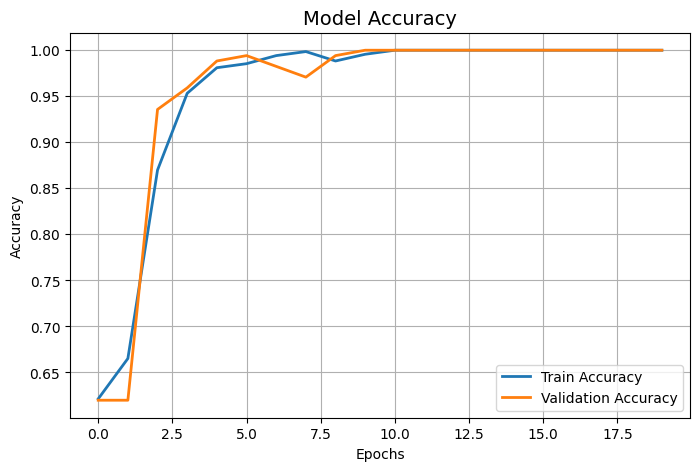

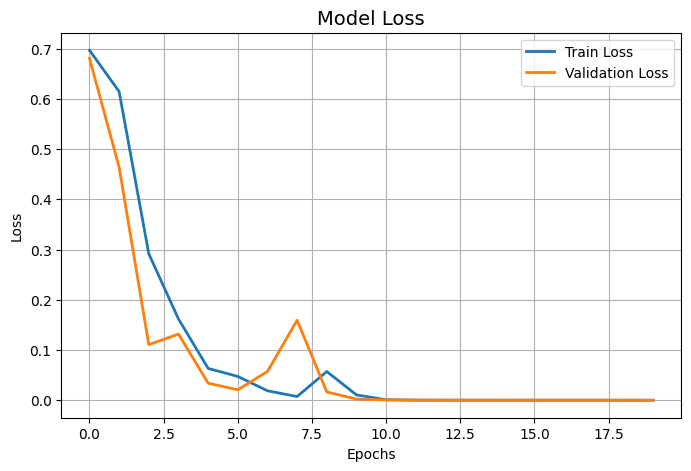

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Model Accuracy", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Model Loss", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00        65

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171



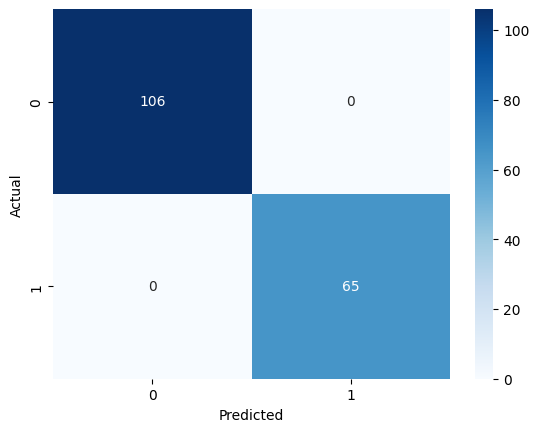

In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

best_model = load_model("best_3dcnn_model.keras")

y_pred = (best_model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [11]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("best_3dcnn_model.keras")


In [12]:
import cv2
import numpy as np

def preprocess_video(video_path, frame_count=16, target_size=(128, 128)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # توزيع متساوي للإطارات
    frame_indices = np.linspace(0, total_frames - 1, frame_count, dtype=int)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        # ✅ تحسين الجودة عند التصغير / التكبير
        frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_CUBIC)

        # ✅ تحويل الألوان من BGR إلى RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # ✅ تعزيز التباين والحدة قليلًا (اختياري)
        frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=10)

        frames.append(frame)

    cap.release()

    # ✅ تحويل إلى numpy وتقسيم على 255 لتطبيع البيانات
    frames = np.array(frames, dtype=np.float32) / 255.0

    return frames


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def predict_video(video_path):
    # 🔹 معالجة الفيديو
    frames = preprocess_video(video_path, frame_count=16, target_size=(128, 128))

    if frames.shape[0] < 16:
        print("⚠️ The video is too short, try with a longer video.")
        return

    # ✅ التأكد من الأبعاد
    X = np.expand_dims(frames, axis=0)  # (1, 16, 128, 128, 3)

    # 🔮 التنبؤ
    prediction = model.predict(X)
    score = float(prediction[0][0])
    label = int(score > 0.5)

    classes = ["🧍‍♂️ Non Shop Lifter", "🕵️‍♂️ Shop Lifter"]

    # 🧠 عرض النتيجة
    print(f"🎯 Prediction: {classes[label]}")
    print(f"📊 Confidence score: {score:.4f}")

    # 🎞️ عرض أول Frame بعد التحسين (للتأكد من الجودة)
    plt.imshow(frames[0])
    plt.title(f"{classes[label]} ({score:.2f})")
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
🎯 Prediction: 🕵️‍♂️ Shop Lifter
📊 Confidence score: 0.9992


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128373 (\N{SLEUTH OR SPY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


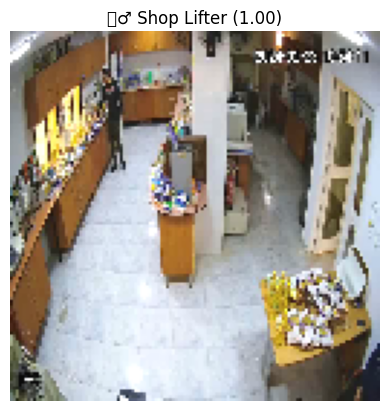

In [14]:
video_path = "/content/Shop_Dataset/Shop DataSet/shop lifters/shop_lifter_100.mp4"
predict_video(video_path)


In [15]:
import os
import cv2
import numpy as np
from glob import glob
import random
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoFeatureExtractor, AutoModelForVideoClassification
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
MODEL_NAME = "MCG-NJU/videomae-base-finetuned-kinetics"
DATA_DIR = "/content/Shop_Dataset/Shop DataSet"
TARGET_SIZE = (224, 224)
FRAME_COUNT = 16
BATCH_SIZE = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("✅ Device:", DEVICE)
print("📦 Model:", MODEL_NAME)

✅ Device: cuda
📦 Model: MCG-NJU/videomae-base-finetuned-kinetics


In [17]:
fe = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
fe.do_rescale = False  # منع إعادة التطبيع

model = AutoModelForVideoClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(DEVICE)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/videomae/feature_extraction_videomae.py:30: FutureWarning: The class VideoMAEFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use VideoMAEImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x VideoMAELayer(
          (attention): VideoMAEAttention(
            (attention): VideoMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
    

In [18]:
def sample_frames_from_video(path, frame_count=FRAME_COUNT, size=TARGET_SIZE):
    cap = cv2.VideoCapture(path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total <= 0:
        cap.release()
        return np.zeros((frame_count, size[0], size[1], 3), dtype=np.float32)

    indices = np.linspace(0, total - 1, frame_count, dtype=int)
    frames = []

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ret, frame = cap.read()
        if not ret:
            frame = frames[-1].copy() if len(frames) > 0 else np.zeros((size[0], size[1], 3), dtype=np.uint8)
        else:
            frame = cv2.resize(frame, (size[1], size[0]), interpolation=cv2.INTER_CUBIC)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()
    frames = np.stack(frames, axis=0).astype(np.float32) / 255.0
    return frames

In [19]:
class VideoDataset(Dataset):
    def __init__(self, data_dir, frame_count=FRAME_COUNT, target_size=TARGET_SIZE):
        self.video_paths = []
        self.labels = []
        self.classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        self.class2idx = {c: i for i, c in enumerate(self.classes)}

        for c in self.classes:
            folder = os.path.join(data_dir, c)
            for ext in ("*.mp4", "*.avi", "*.mov", "*.mkv"):
                for path in glob(os.path.join(folder, ext)):
                    self.video_paths.append(path)
                    self.labels.append(self.class2idx[c])

        self.frame_count = frame_count
        self.target_size = target_size

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        frames = sample_frames_from_video(path, frame_count=self.frame_count, size=self.target_size)
        label = self.labels[idx]
        frames = torch.tensor(frames, dtype=torch.float32).permute(0, 3, 1, 2)  # (F, C, H, W)
        return frames, label, path

In [20]:
dataset = VideoDataset(DATA_DIR)
print(f"✅ Found {len(dataset)} videos across classes: {dataset.classes}")


indices = list(range(len(dataset)))
random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx, test_idx = indices[:split], indices[split:]

train_ds = Subset(dataset, train_idx)
test_ds = Subset(dataset, test_idx)

✅ Found 855 videos across classes: ['non shop lifters', 'shop lifters']


In [21]:
def collate_fn(batch):
    frames_list = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    paths = [item[2] for item in batch]

    inputs = torch.stack(frames_list)  # (B, F, C, H, W)
    inputs = {"pixel_values": inputs}

    return inputs, labels, paths

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [22]:
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    for enc, labels, paths in tqdm(dataloader, desc="Evaluating"):
        enc = {k: v.to(device) for k, v in enc.items()}
        labels = labels.to(device)

        outputs = model(**enc)
        preds = outputs.logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    return acc, all_preds, all_labels

In [23]:
acc, preds, labels = evaluate(model, test_loader, DEVICE)
print(f"\n🎯 Test Accuracy: {acc * 100:.2f}%")

print("\n📊 Classification Report:")
print(classification_report(labels, preds, target_names=dataset.classes))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(labels, preds))

Evaluating: 100%|██████████| 86/86 [02:30<00:00,  1.75s/it]


🎯 Test Accuracy: 66.67%

📊 Classification Report:
                  precision    recall  f1-score   support

non shop lifters       0.67      0.93      0.78       107
    shop lifters       0.65      0.23      0.34        64

        accuracy                           0.67       171
       macro avg       0.66      0.58      0.56       171
    weighted avg       0.66      0.67      0.61       171


📉 Confusion Matrix:
[[99  8]
 [49 15]]


In [1]:
!pip install --upgrade transformers accelerate


In [2]:
import os
import cv2
import numpy as np
from glob import glob
import random
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from transformers import AutoFeatureExtractor, AutoModelForVideoClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
MODEL_NAME = "MCG-NJU/videomae-base-finetuned-kinetics"
DATA_DIR = "/content/Shop_Dataset/Shop DataSet"
FRAME_COUNT = 16
TARGET_SIZE = (224, 224)
BATCH_SIZE = 2
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("✅ Device:", DEVICE)
print("📦 Model:", MODEL_NAME)

✅ Device: cuda
📦 Model: MCG-NJU/videomae-base-finetuned-kinetics


In [4]:
fe = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
fe.do_rescale = False  # نمنع التحجيم مرتين

model = AutoModelForVideoClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/videomae/feature_extraction_videomae.py:30: FutureWarning: The class VideoMAEFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use VideoMAEImageProcessor instead.
  warnings.warn(
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- clas

In [5]:
def load_video(path, num_frames=16, size=(224, 224), augment=False):
    cap = cv2.VideoCapture(path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0:
        cap.release()
        return np.zeros((num_frames, size[0], size[1], 3), dtype=np.float32)

    indices = np.linspace(0, total - 1, num_frames, dtype=int)
    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            frame = np.zeros((size[0], size[1], 3), dtype=np.uint8)
        else:
            frame = cv2.resize(frame, (size[1], size[0]))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if augment and random.random() > 0.5:
                frame = cv2.flip(frame, 1)
        frames.append(frame)
    cap.release()
    frames = np.stack(frames, axis=0).astype(np.float32)
    return frames

In [6]:
class VideoDataset(Dataset):
    def __init__(self, data_dir, feature_extractor, num_frames=16, augment=False):
        self.data_dir = data_dir
        self.fe = feature_extractor
        self.num_frames = num_frames
        self.augment = augment
        self.videos, self.labels = [], []
        self.classes = sorted(os.listdir(data_dir))

        for label, cls in enumerate(self.classes):
            folder = os.path.join(data_dir, cls)
            for vid in os.listdir(folder):
                if vid.endswith(('.mp4', '.avi', '.mov')):
                    self.videos.append(os.path.join(folder, vid))
                    self.labels.append(label)

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        path = self.videos[idx]
        label = self.labels[idx]
        frames = load_video(path, num_frames=self.num_frames, augment=self.augment)
        frames = np.transpose(frames, (0, 3, 1, 2))  # (T, C, H, W)
        enc = self.fe(list(frames), return_tensors="pt")
        enc = {k: v.squeeze(0) for k, v in enc.items()}
        return enc, torch.tensor(label), path

In [7]:
dataset = VideoDataset(DATA_DIR, fe)
indices = list(range(len(dataset)))
random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx, test_idx = indices[:split], indices[split:]

train_ds = Subset(VideoDataset(DATA_DIR, fe, augment=True), train_idx)
test_ds = Subset(VideoDataset(DATA_DIR, fe, augment=False), test_idx)

In [8]:
def collate_fn(batch):
    enc_list = [b[0] for b in batch]
    labels = torch.tensor([b[1] for b in batch])
    paths = [b[2] for b in batch]

    pixel_values = torch.stack([enc["pixel_values"] for enc in enc_list])
    return {"pixel_values": pixel_values}, labels, paths

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [9]:
optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct, total = 0, 0  # ✅ لحساب الدقة

    for enc, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        labels = labels.to(DEVICE)

        # 🔹 Forward pass
        outputs = model(**enc)
        loss = loss_fn(outputs.logits, labels)

        # 🔹 Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        # ✅ حساب accuracy
        preds = outputs.logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100

    print(f"✅ Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

Epoch 1/10: 100%|██████████| 342/342 [14:35<00:00,  2.56s/it]


✅ Epoch 1/10 | Loss: 0.7242 | Accuracy: 57.31%


Epoch 2/10: 100%|██████████| 342/342 [14:26<00:00,  2.53s/it]


✅ Epoch 2/10 | Loss: 0.6690 | Accuracy: 60.23%


Epoch 3/10: 100%|██████████| 342/342 [14:34<00:00,  2.56s/it]


✅ Epoch 3/10 | Loss: 0.5650 | Accuracy: 73.10%


Epoch 4/10: 100%|██████████| 342/342 [14:36<00:00,  2.56s/it]


✅ Epoch 4/10 | Loss: 0.3112 | Accuracy: 89.04%


Epoch 5/10: 100%|██████████| 342/342 [14:30<00:00,  2.55s/it]


✅ Epoch 5/10 | Loss: 0.1680 | Accuracy: 93.27%


Epoch 6/10: 100%|██████████| 342/342 [14:29<00:00,  2.54s/it]


✅ Epoch 6/10 | Loss: 0.0997 | Accuracy: 97.81%


Epoch 7/10: 100%|██████████| 342/342 [14:28<00:00,  2.54s/it]


✅ Epoch 7/10 | Loss: 0.0610 | Accuracy: 98.54%


Epoch 8/10: 100%|██████████| 342/342 [15:18<00:00,  2.69s/it]


✅ Epoch 8/10 | Loss: 0.0427 | Accuracy: 99.56%


Epoch 9/10: 100%|██████████| 342/342 [15:53<00:00,  2.79s/it]


✅ Epoch 9/10 | Loss: 0.0351 | Accuracy: 99.12%


Epoch 10/10: 100%|██████████| 342/342 [15:43<00:00,  2.76s/it]

✅ Epoch 10/10 | Loss: 0.0246 | Accuracy: 99.56%


In [11]:
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    for enc, labels, _ in tqdm(dataloader, desc="Evaluating"):
        enc = {k: v.to(device) for k, v in enc.items()}
        labels = labels.to(device)

        outputs = model(**enc)
        preds = outputs.logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    return acc, all_preds, all_labels

In [12]:
acc, preds, labels = evaluate(model, test_loader, DEVICE)
print(f"\n🎯 Test Accuracy: {acc*100:.2f}%")

print("\n📊 Classification Report:")
print(classification_report(labels, preds, target_names=dataset.classes))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(labels, preds))


Evaluating: 100%|██████████| 86/86 [03:10<00:00,  2.21s/it]


🎯 Test Accuracy: 97.66%

📊 Classification Report:
                  precision    recall  f1-score   support

non shop lifters       0.97      1.00      0.98       117
    shop lifters       1.00      0.93      0.96        54

        accuracy                           0.98       171
       macro avg       0.98      0.96      0.97       171
    weighted avg       0.98      0.98      0.98       171


📉 Confusion Matrix:
[[117   0]
 [  4  50]]


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ===========================
# 🎥 دالة لتوقع فيديو واحد
# ===========================
def predict_video(video_path, model, feature_extractor, device, frame_count=16, target_size=(224, 224)):
    model.eval()

    # 🔹 تحميل الفريمات من الفيديو
    frames = load_video(video_path, num_frames=frame_count, size=target_size, augment=False)
    frames = np.transpose(frames, (0, 3, 1, 2))  # (T, C, H, W)

    # 🔹 تحويل الفريمات إلى tensors باستخدام الـ feature extractor
    enc = feature_extractor(list(frames), return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}

    # 🔮 التنبؤ
    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        conf, pred = torch.max(probs, dim=-1)

    # ✅ استخراج النتيجة
    classes = dataset.classes
    predicted_class = classes[pred.item()]
    confidence = conf.item() * 100

    # 🎯 طباعة النتيجة
    print(f"🎬 Video: {os.path.basename(video_path)}")
    print(f"🧠 Prediction: {predicted_class}")
    print(f"📊 Confidence: {confidence:.2f}%")

    # 🎞️ عرض أول Frame
    plt.imshow(frames[0].transpose(1, 2, 0).astype(np.uint8))
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()


🎬 Video: videppppsss_37.mp4
🧠 Prediction: non shop lifters
📊 Confidence: 98.91%


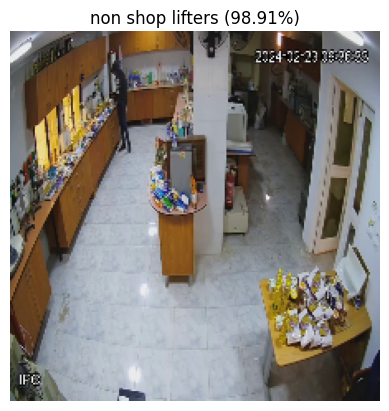

In [14]:
# جرب على فيديو من فولدر test
sample_video = test_ds.dataset.videos[0]  # أو مسار أي فيديو تاني عندك
predict_video(sample_video, model, fe, DEVICE)
